# Trading Interview Game

Now we have introduced CFR and understand the basics, lets try apply it to a problem inspired by a real interview question from a top quantitative trading firm.

## The Game - Part 1

The game starts with two players, both have to submit a number between 0 and 100 on a piece of paper. After the numbers are submitted, the papers are checked and whoever submitted the larger number must pay the other player their number. 

A few examples:
* Player A submits 90, Player B submits 10. Player B wins so receives \$10.
* Player A submits 15, Player B submits 20. Player A wins so receives \$15.
* Player A submits 1, Player B submits 99. Player A wins so receives \$1.

Imagine you are playing this game and versing an opponent who submits a random number between 1 and 100.
The warm-up question, which can be solved with just paper and pen, is to calculate the optimal number for you to submit, such that you maximise you expected value in this game. 




## Part 1 - Solution

Let $X$ be the number we submit. We can write the probability we win as 
$$
P(X) = 1 - \frac{X}{100}
$$
The payout when we win is simply $X$. The payout when we lose is the other players number. As this will be distributed uniformly between 0 and $X$, the loss will be on average, $X/2$. Therefore we write the expected value as
$$
\mathbb{E}(X) = X P(X) - \frac{X}{2} (1 - P(X)) = X - \frac{3 X^2}{200}
$$

Now we just solve for the maximum of this function (take derivative and set to zero) to get $X_0 = 33$.




## The Game - Part 2

Now we introduce a third player to the game who is perfectly rational, as are you, and there is still a player who submits a random bid. The penalty for losing a game is now greater, as the person who submits the highest number must now pay all the other players their number. If there is a tie for highest bid, they each pay half of the third players number.

For example:
* Player A submits 50, Player B submits 40, Player C submits 30. A loses so pays B \\$40 and pays C \\$30.
* Player A submits 20, Player B submits 50, Player C submits 50. B and C tie to lose, so both pay A \\$10 each.


Our previous strategy of picking a single number is no longer profitable as we will get exploited by the new player. It is likely we will now need to play a mixed strategy. Let's try solve this problem using CFR where we will find the nash equilibrium between player A and player B, and play this strategy to maximise our expected value. 

It is worth trying to solve this problem with just pen and paper too, as would be expected in an interview. We have therefore leftout the graph showing the answer and have it in the solutions document.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
N = 101
actions = np.arange(1, N)

In [2]:
'''
Tip: to speedup the computation, we can incorporate the randomness 
of player C's bid into our payoff function by taking an average over 
all 100 possible choices, instead of actually choosing a random number for player C.
'''

# hero number is first
def game_outcome(numbers: list[int]) -> int:
    m = max(numbers)
    max_index = [i for i, j in enumerate(numbers) if j == m]

    outcome = numbers.copy()

    if len(max_index) == 1:
        loss = m - sum(numbers)
        outcome[max_index[0]] = loss

        return outcome[0]

    if len(max_index) == 2:
        loss = m - sum(numbers) / 2
        outcome[max_index[0]] = loss
        outcome[max_index[1]] = loss

        return outcome[0]

    if len(max_index) == 3:
        return 0


In [3]:
'''
Action is the number to submit (100 possible actions)
'''

def payoff(hero_action: int, villain_strategy: np.array(float)) -> float:
    '''
    PAYOFF FUNCTION HERE
    '''
    EV = 0

    for i in range(N):
        for j in range(N):
            nums = [hero_action, i, j]
            EV += game_outcome(nums) * 1/100 * villain_strategy[i]

    return EV

    

In [7]:
'''
Calculate immediate regret for every action
'''
def calculate_immediate_regret(hero_strategy: np.array(float), villain_strategy: np.array(float)) -> np.array(float):
    '''
    IMMEDIATE REGRET 
    '''
    hero_EV = 0
    for a in actions:
        hero_EV += hero_strategy[a] * payoff(a, villain_strategy)

    regrets = np.zeros(N)
    
    for a in actions:
        regrets[a] = payoff(a, villain_strategy) - hero_EV

    return regrets



In [8]:

'''
Calculate new strategy based on accumulated regret for the hero
'''

def calculate_strategy(acc_regrets: np.array(float)) -> np.array(float):
    '''
    CALCULATE NEW STRATEGY
    '''
    positive_regret = np.where(acc_regrets > 0, acc_regrets, 0)

    normalisation = np.sum(positive_regret)

    if normalisation == 0:
        return np.ones(N) / N
        
    return positive_regret / normalisation
        



In [9]:
'''
Run CFR algorithm.
We set initial strategy for player A and B to both pick rock 100% of the time. 
'''

strategyA = np.ones(N) / N
strategyB = np.ones(N) / N

acc_regretsA = np.zeros(N)
acc_regretsB = np.zeros(N)

steps = 100

strat_history = []
strat_history_B = []

for t in range(steps):
    acc_regretsA += calculate_immediate_regret(strategyA, strategyB)
    strategyA = calculate_strategy(acc_regretsA)
    
    acc_regretsB += calculate_immediate_regret(strategyB, strategyA)
    strategyB = calculate_strategy(acc_regretsB)

    strat_history.append(strategyA)
    strat_history_B.append(strategyB)


In [10]:
strat_history = np.array(strat_history)

avg_strats = np.cumsum(strat_history, axis=0)
norm = np.sum(avg_strats, axis=1)[:,None]

strats = avg_strats / norm

nash_strat = strats[-1]

In [11]:
strat_history_B = np.array(strat_history_B)

avg_strats_B = np.cumsum(strat_history_B, axis=0)
norm = np.sum(avg_strats_B, axis=1)[:,None]

stratsB = avg_strats_B / norm

nash_strat_B = stratsB[-1]

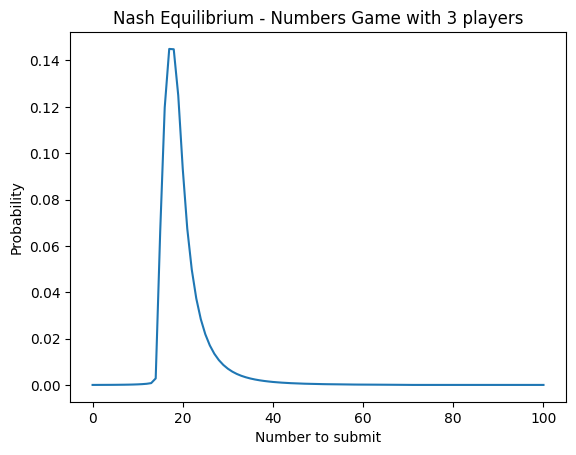

In [16]:
fig, ax = plt.subplots()

ax.plot(nash_strat)
ax.set_title('Nash Equilibrium - Numbers Game with 3 players')
ax.set_xlabel('Number to submit')
ax.set_ylabel('Probability')
# plt.show()
plt.savefig('figs/numbers_game_nash.png')

In [14]:
hero_EV = 0
for a in actions:
    hero_EV += nash_strat[a] * payoff(a, nash_strat_B)

print(hero_EV)

14.06365399240168
